In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from data.datamodule import ArlFeAl2O3EdxDataModule


In [9]:
def extract_patches(image, patch_size=128):
    h, w = image.shape[:2]
    n_h, n_w = h // patch_size, w // patch_size
    
    patches = []
    positions = []
    
    for i in range(n_h):
        for j in range(n_w):
            start_h, start_w = i * patch_size, j * patch_size
            end_h, end_w = start_h + patch_size, start_w + patch_size
            
            patch = image[start_h:end_h, start_w:end_w]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
                positions.append((i, j, start_h, start_w))
    
    return patches, positions

def process_image_pair(bse_img, edx_img, label):
    bse_array = np.array(bse_img)
    edx_array = np.array(edx_img)
    
    if bse_array.shape[:2] != edx_array.shape[:2]:
        raise ValueError(f"Shape mismatch: BSE {bse_array.shape[:2]} vs EDX {edx_array.shape[:2]}")
    
    bse_patches, bse_pos = extract_patches(bse_array)
    edx_patches, edx_pos = extract_patches(edx_array)
    
    return {
        'bse_patches': bse_patches,
        'edx_patches': edx_patches,
        'positions': bse_pos,
        'label': label,
        'count': len(bse_patches)
    }

def setup_datamodule(data_dir='./data', split='test', discriminative=True, train_ratio=0.8):
    dm = ArlFeAl2O3EdxDataModule(
        data_dir=data_dir,
        discriminative=discriminative,
        train_ratio=train_ratio,
        val_ratio=0.0 if train_ratio == 1.0 else 0.1,
        test_ratio=0.0 if train_ratio == 1.0 else 0.1,
        batch_size=1,
        num_workers=0,
        seed=42
    )
    dm.setup(stage='fit')  # Use 'fit' instead of 'train'
    
    datasets = {'train': dm.train_dataset, 'val': dm.val_dataset, 'test': dm.test_dataset}
    return datasets.get(split)

def load_and_process_data(data_dir='./data', split='test', discriminative=True, train_ratio=0.8):
    dataset = setup_datamodule(data_dir, split, discriminative, train_ratio)
    if dataset is None:
        print(f"No dataset found for split: {split}")
        return []
    
    samples = []
    for i in range(len(dataset)):
        bse_img, edx_img, label = dataset[i]
        if isinstance(label, torch.Tensor):
            label = tuple(label.tolist())
        
        sample = process_image_pair(bse_img, edx_img, label)
        samples.append(sample)
    
    return samples



In [10]:
samples = load_and_process_data('./data', 'train', discriminative=True, train_ratio=1.0)

print(f"Loaded {len(samples)} samples")
if samples:
    total_patches = sum(s['count'] for s in samples)
    print(f"Total patches: {total_patches}")
    print(f"Average patches per sample: {total_patches/len(samples):.1f}")
    
    # Show label distribution
    labels = [s['label'] for s in samples]
    unique_labels = list(set(labels))
    print(f"Unique labels: {len(unique_labels)}")
    
    # Display first few samples
    for i, sample in enumerate(samples[:3]):
        print(f"Sample {i}: Label {sample['label']}, Patches: {sample['count']}")
        if sample['bse_patches']:
            bse_shape = sample['bse_patches'][0].shape
            edx_shape = sample['edx_patches'][0].shape
            print(f"  Patch shapes - BSE: {bse_shape}, EDX: {edx_shape}")
else:
    print("No samples found. Check data directory and split.")


Indexing data in /project/haix/isee/nwen/arl_edx_chromagan ...
Indexing data in /project/haix/isee/nwen/arl_edx_chromagan ...
Loaded 45 samples
Total patches: 1474
Average patches per sample: 32.8
Unique labels: 9
Sample 0: Label (0.5, 0.7), Patches: 35
  Patch shapes - BSE: (128, 128), EDX: (128, 128, 3)
Sample 1: Label (0.2, 0.5), Patches: 28
  Patch shapes - BSE: (128, 128), EDX: (128, 128, 3)
Sample 2: Label (0.5, 0.7), Patches: 35
  Patch shapes - BSE: (128, 128), EDX: (128, 128, 3)


In [20]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class PatchData:
    BSE_image: torch.Tensor
    EDX_map: torch.Tensor
    EDX_type: str
    Fe_comp: float
    laser_speed: float
    Fe_pred: float
    laser_speed_pred: float
    image_idx: int
    patch_idx: int
    position: Tuple[int, int, int, int]  # (grid_i, grid_j, start_h, start_w)

def create_patch_objects(samples):
    patch_objects = []
    
    for image_idx, sample in enumerate(samples):
        Fe_comp, laser_speed = sample['label']
        
        for patch_idx, (bse_patch, edx_patch, position) in enumerate(zip(sample['bse_patches'], sample['edx_patches'], sample['positions'])):
            # Convert numpy arrays to tensors
            bse_tensor = torch.from_numpy(bse_patch.astype(np.float32))
            edx_tensor = torch.from_numpy(edx_patch.astype(np.float32))
            
            # For BSE: add channel dimension if grayscale
            if bse_tensor.dim() == 2:
                bse_tensor = bse_tensor.unsqueeze(0)  # (H, W) -> (1, H, W)
            elif bse_tensor.dim() == 3:
                bse_tensor = bse_tensor.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            
            # For EDX: ensure correct channel order
            if edx_tensor.dim() == 3:
                edx_tensor = edx_tensor.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            
            patch_obj = PatchData(
                BSE_image=bse_tensor,
                EDX_map=edx_tensor,
                EDX_type='Original',
                Fe_comp=Fe_comp,
                laser_speed=laser_speed,
                Fe_pred=0,
                laser_speed_pred=0,
                image_idx=image_idx,
                patch_idx=patch_idx,
                position=position
            )
            
            patch_objects.append(patch_obj)
    
    return patch_objects

def stitch_patches(patch_list, patch_size=128, image_type='EDX'):
    """
    Stitch patches back together to reconstruct the original image.
    
    Args:
        patch_list: List of PatchData objects for the same image
        patch_size: Size of each patch (default 128)
        image_type: 'BSE' or 'EDX' to specify which image to reconstruct
    
    Returns:
        Reconstructed image as numpy array
    """
    if not patch_list:
        return None
    
    # Determine output dimensions based on patch positions
    max_grid_i = max(pos[0] for pos in [p.position for p in patch_list])
    max_grid_j = max(pos[1] for pos in [p.position for p in patch_list])
    
    # Calculate output image dimensions
    output_h = (max_grid_i + 1) * patch_size
    output_w = (max_grid_j + 1) * patch_size
    
    # Get the first patch to determine number of channels
    first_patch = patch_list[0]
    if image_type == 'BSE':
        sample_tensor = first_patch.BSE_image
    else:
        sample_tensor = first_patch.EDX_map
    
    # Convert tensor format (C, H, W) back to (H, W, C) for reconstruction
    if sample_tensor.dim() == 3:
        n_channels = sample_tensor.shape[0]
        output_shape = (output_h, output_w, n_channels)
    else:
        output_shape = (output_h, output_w)
    
    # Initialize output image
    reconstructed = np.zeros(output_shape)
    
    # Place each patch in the correct position
    for patch in patch_list:
        grid_i, grid_j, start_h, start_w = patch.position
        
        if image_type == 'BSE':
            patch_data = patch.BSE_image
        else:
            patch_data = patch.EDX_map
        
        # Convert from tensor to numpy and adjust dimensions
        if isinstance(patch_data, torch.Tensor):
            patch_array = patch_data.detach().cpu().numpy()
        else:
            patch_array = patch_data
        
        # Convert from (C, H, W) to (H, W, C) format
        if patch_array.ndim == 3 and patch_array.shape[0] <= 3:  # Channels first
            patch_array = np.transpose(patch_array, (1, 2, 0))
        elif patch_array.ndim == 2:  # Grayscale
            pass  # Keep as is
        
        # Calculate placement position
        place_h = grid_i * patch_size
        place_w = grid_j * patch_size
        
        # Place the patch
        if patch_array.ndim == 3:
            reconstructed[place_h:place_h + patch_size, place_w:place_w + patch_size, :] = patch_array
        else:
            reconstructed[place_h:place_h + patch_size, place_w:place_w + patch_size] = patch_array
    
    return reconstructed

patch_objects = create_patch_objects(samples)

In [42]:
original_patches = {(pobj.image_idx, pobj.patch_idx): pobj for pobj in patch_objects}
original_patches

{(0,
  0): PatchData(BSE_image=tensor([[[163., 166., 166.,  ...,  78.,  76.,  75.],
          [166., 168., 168.,  ...,  81.,  80.,  76.],
          [168., 169., 169.,  ...,  86.,  80.,  78.],
          ...,
          [118., 120., 120.,  ...,  97.,  99.,  99.],
          [118., 118., 121.,  ..., 102., 102., 104.],
          [120., 118., 120.,  ..., 102., 102., 102.]]]), EDX_map=tensor([[[ 70.,  70.,   0.,  ...,   0.,  70.,  70.],
          [ 70., 181.,   0.,  ..., 252.,   0.,   0.],
          [ 70., 181., 141.,  ...,   0.,   0.,   0.],
          ...,
          [ 70.,   0.,  70.,  ...,   0.,   0.,   0.],
          [141.,  70.,  70.,  ...,   0.,  70.,   0.],
          [141.,  70., 141.,  ...,  70.,   0.,  70.]],
 
         [[ 64., 131., 192.,  ..., 255., 108.,  88.],
          [108.,  44.,  42.,  ...,  64., 214., 170.],
          [128.,  44.,  42.,  ..., 150.,  64.,  64.],
          ...,
          [ 42., 150., 105.,  ...,   0.,  64.,  64.],
          [105., 192.,  64.,  ..., 192.,   0.,  

In [29]:
checkpoints = {
    'exp-32': 'outputs/2025-03-28/14-27-37/checkpoints/checkpoint-epoch=9999.ckpt'
}

import sys
sys.path.append('.')
from main128 import EDXGAN, Generator

def load_checkpoint_to_gpu(checkpoint_path, device='cuda'):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        # Remove 'net_g.' prefix for generator weights
        generator_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('net_g.'):
                generator_state_dict[key[6:]] = value
    else:
        generator_state_dict = checkpoint
    
    # Initialize and load generator
    generator = Generator()
    generator.load_state_dict(generator_state_dict)
    generator.to(device)
    generator.eval()
    
    print(f"✓ Checkpoint loaded to {device}")
    return generator

# Load checkpoints to GPU
models = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

for name, checkpoint_path in checkpoints.items():
    models[name] = load_checkpoint_to_gpu(checkpoint_path, device)




Using device: cuda
Loading checkpoint from outputs/2025-03-28/14-27-37/checkpoints/checkpoint-epoch=9999.ckpt...


/home/nwen/micromamba/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Default pretrained checkpoint loaded
✓ Checkpoint loaded to cuda


In [35]:
batch_size = 32
generated_patches = []

# Run inference with loaded models
for model_name, model in models.items():
    print(f"\nRunning inference with {model_name}...")
    
    for i in range(0, len(patch_objects), batch_size):
        batch = patch_objects[i:i + batch_size]
        
        # Stack BSE images into a batch tensor
        bse_batch = torch.stack([sample.BSE_image for sample in batch]).to(device)
        bse_batch = (bse_batch / 255.0) * 2 - 1  # Normalize to [-1, 1]
        
        with torch.no_grad():
            edx_gen, labels_pred = model(bse_batch)
        
        for j in range(len(batch)):
            gen_sample = PatchData(
                BSE_image=batch[j].BSE_image,
                EDX_map=edx_gen[j].detach().cpu(),
                EDX_type=model_name,
                Fe_comp=batch[j].Fe_comp,
                laser_speed=batch[j].laser_speed,
                Fe_pred=labels_pred[j][0].item(),
                laser_speed_pred=labels_pred[j][1].item(),
                image_idx=batch[j].image_idx,
                patch_idx=batch[j].patch_idx,
                position=batch[j].position
            )
            generated_patches.append(gen_sample)








Running inference with exp-32...


In [36]:
df = pd.DataFrame(generated_patches)
df

BSE_image  \
0     [[[tensor(163.), tensor(166.), tensor(166.), t...   
1     [[[tensor(73.), tensor(72.), tensor(70.), tens...   
2     [[[tensor(198.), tensor(201.), tensor(201.), t...   
3     [[[tensor(104.), tensor(102.), tensor(100.), t...   
4     [[[tensor(160.), tensor(156.), tensor(152.), t...   
...                                                 ...   
1469  [[[tensor(107.), tensor(107.), tensor(109.), t...   
1470  [[[tensor(89.), tensor(89.), tensor(92.), tens...   
1471  [[[tensor(58.), tensor(58.), tensor(58.), tens...   
1472  [[[tensor(133.), tensor(133.), tensor(131.), t...   
1473  [[[tensor(221.), tensor(221.), tensor(221.), t...   

                                                EDX_map EDX_type  Fe_comp  \
0     [[[tensor(-0.1905), tensor(-0.1971), tensor(-0...   exp-32      0.5   
1     [[[tensor(-0.5787), tensor(-0.6919), tensor(-0...   exp-32      0.5   
2     [[[tensor(0.0829), tensor(0.0937), tensor(0.13...   exp-32      0.5   
3     [[[tensor(-0.5806), tensor(-0.6794), tensor(-0...   exp-32      0.5   
4     [[[tensor(-0.5113), tensor(-0.5976), tensor(-0...   exp-32      0.5   
...                                                 ...      ...      ...   
1469  [[[tensor(-0.6193), tensor(-0.7275), tensor(-0...   exp-32      0.4   
1470  [[[tensor(-0.5045), tensor(-0.5827), tensor(-0...   exp-32      0.4   
1471  [[[tensor(-0.6237), tensor(-0.7245), tensor(-0...   exp-32      0.4   
1472  [[[tensor(-0.5117), tensor(-0.6075), tensor(-0...   exp-32      0.4   
1473  [[[tensor(0.1893), tensor(0.1943), tensor(0.26...   exp-32      0.4   

      laser_speed   Fe_pred  laser_speed_pred  image_idx  patch_idx  \
0             0.7  0.506334          0.730648          0          0   
1             0.7  0.483361          0.666015          0          1   
2             0.7  0.521056          0.766750          0          2   
3             0.7  0.474131          0.698183          0          3   
4             0.7  0.490523          0.648720          0          4   
...           ...       ...               ...        ...        ...   
1469          0.7  0.398331          0.691095         44         19   
1470          0.7  0.393035          0.681811         44         20   
1471          0.7  0.388100          0.722104         44         21   
1472          0.7  0.387814          0.688528         44         22   
1473          0.7  0.385908          0.721690         44         23   

              position  
0         (0, 0, 0, 0)  
1       (0, 1, 0, 128)  
2       (0, 2, 0, 256)  
3       (0, 3, 0, 384)  
4       (0, 4, 0, 512)  
...                ...  
1469  (3, 1, 384, 128)  
1470  (3, 2, 384, 256)  
1471  (3, 3, 384, 384)  
1472  (3, 4, 384, 512)  
1473  (3, 5, 384, 640)  

[1474 rows x 10 columns]

In [37]:
# Reconstruct and visualize the first image (image_idx=0)
image_idx = 0

# Get patches for the first image - original
original_patches_img0 = [p for p in patch_objects if p.image_idx == image_idx]
# Get patches for the first image - generated
generated_patches_img0 = [p for p in generated_patches if p.image_idx == image_idx]

print(f"Image {image_idx}:")
print(f"Original patches: {len(original_patches_img0)}")
print(f"Generated patches: {len(generated_patches_img0)}")

if original_patches_img0:
    print(f"Label: Fe={original_patches_img0[0].Fe_comp}, Laser Speed={original_patches_img0[0].laser_speed}")
    print(f"Model: {generated_patches_img0[0].EDX_type}")

# Reconstruct BSE and EDX images
bse_original = stitch_patches(original_patches_img0, patch_size=128, image_type='BSE')
edx_original = stitch_patches(original_patches_img0, patch_size=128, image_type='EDX')
bse_generated = stitch_patches(generated_patches_img0, patch_size=128, image_type='BSE')
edx_generated = stitch_patches(generated_patches_img0, patch_size=128, image_type='EDX')

if bse_original is not None and edx_original is not None and edx_generated is not None:
    print(f"BSE original shape: {bse_original.shape}")
    print(f"EDX original shape: {edx_original.shape}")
    print(f"EDX generated shape: {edx_generated.shape}")

    # Display statistics
    print(f"\nImage statistics:")
    print(f"BSE original - Min: {bse_original.min():.3f}, Max: {bse_original.max():.3f}, Mean: {bse_original.mean():.3f}")
    print(f"EDX original - Min: {edx_original.min():.3f}, Max: {edx_original.max():.3f}, Mean: {edx_original.mean():.3f}")
    print(f"EDX generated - Min: {edx_generated.min():.3f}, Max: {edx_generated.max():.3f}, Mean: {edx_generated.mean():.3f}")
else:
    print("Error: Could not reconstruct one or more images")


Image 0:
Original patches: 35
Generated patches: 35
Label: Fe=0.5, Laser Speed=0.7
Model: exp-32
BSE original shape: (640, 896, 1)
EDX original shape: (640, 896, 3)
EDX generated shape: (640, 896, 3)

Image statistics:
BSE original - Min: 0.000, Max: 255.000, Mean: 122.007
EDX original - Min: 0.000, Max: 255.000, Mean: 78.642
EDX generated - Min: -0.890, Max: 0.553, Mean: -0.387


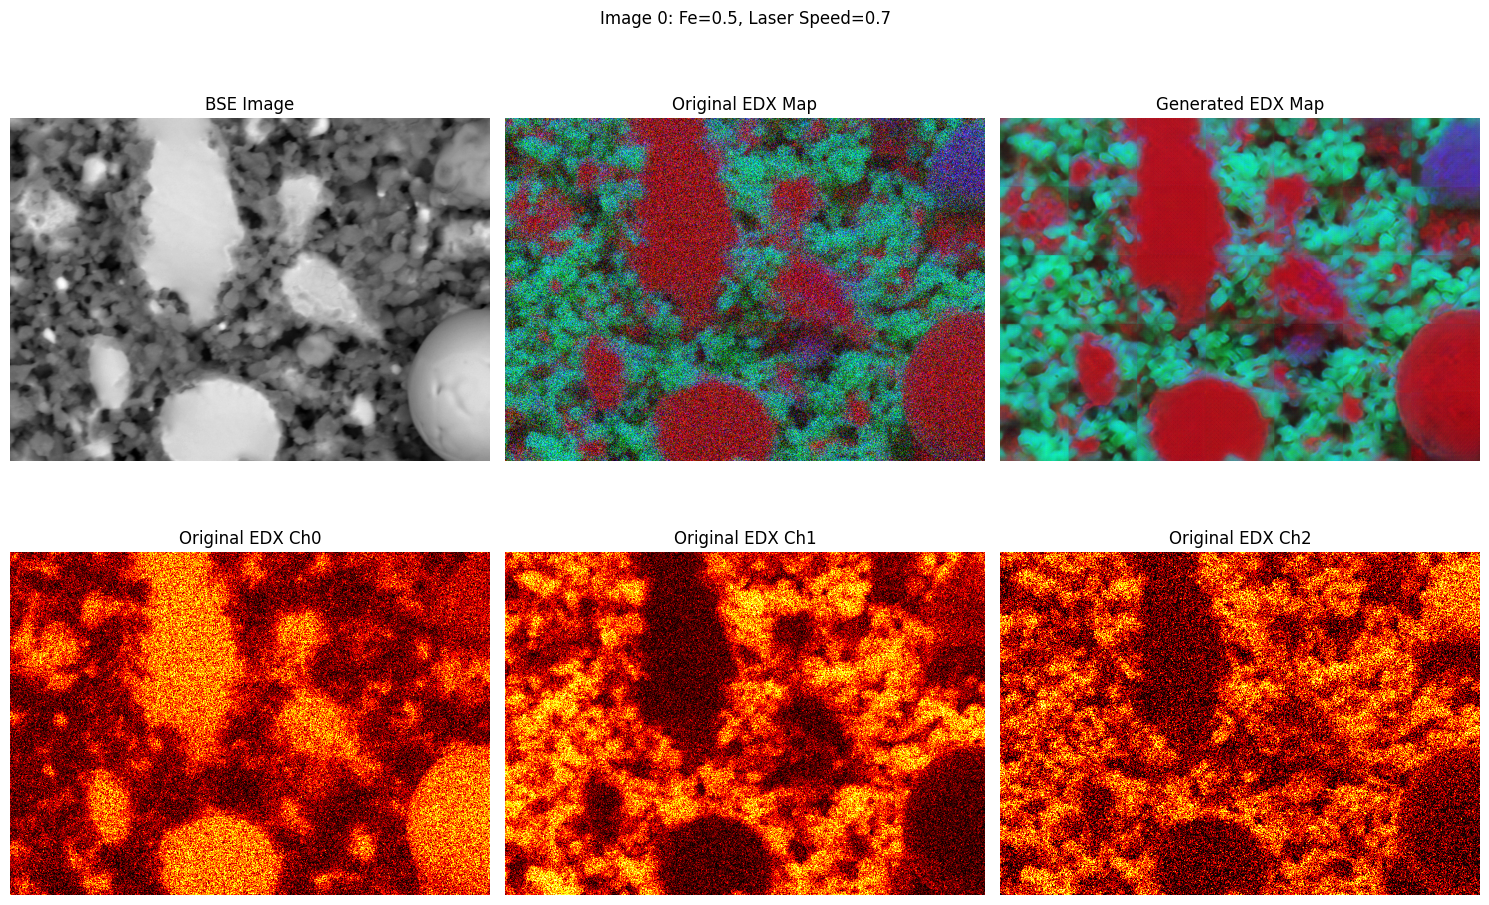

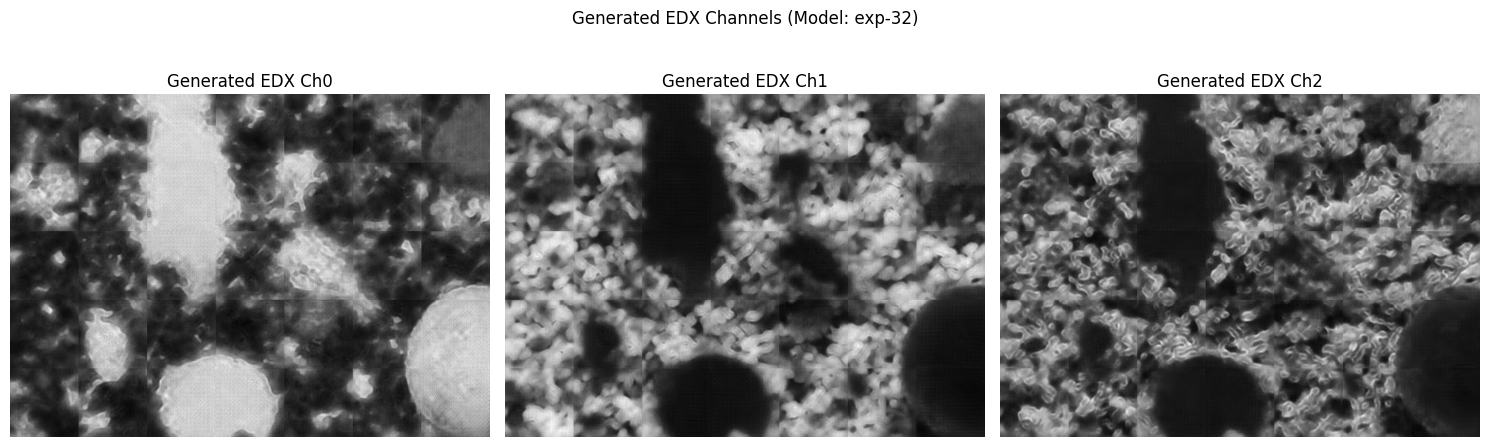

In [43]:
# Create visualization of original vs generated images
if bse_original is not None and edx_original is not None and edx_generated is not None:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Normalize images for display
    bse_display = bse_original.squeeze() if bse_original.ndim == 3 else bse_original
    
    # For EDX maps, handle potential negative values by normalizing to [0, 1]
    edx_orig_norm = (edx_original - edx_original.min()) / (edx_original.max() - edx_original.min())
    edx_gen_norm = (edx_generated - edx_generated.min()) / (edx_generated.max() - edx_generated.min())
    # edx_orig_norm=edx_original
    # edx_gen_norm=edx_generated
    
    # Display BSE image
    axes[0, 0].imshow(bse_display, cmap='gray')
    axes[0, 0].set_title('BSE Image')
    axes[0, 0].axis('off')
    
    # Display original EDX map
    axes[0, 1].imshow(edx_orig_norm, cmap='gray')
    axes[0, 1].set_title('Original EDX Map')
    axes[0, 1].axis('off')
    
    # Display generated EDX map
    axes[0, 2].imshow(edx_gen_norm, cmap='gray')
    axes[0, 2].set_title('Generated EDX Map')
    axes[0, 2].axis('off')
    
    # Display individual channels for original EDX
    for i in range(3):
        axes[1, i].imshow(edx_orig_norm[:, :, i], cmap='hot')
        axes[1, i].set_title(f'Original EDX Ch{i}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Image {image_idx}: Fe={original_patches_img0[0].Fe_comp}, Laser Speed={original_patches_img0[0].laser_speed}')
    plt.tight_layout()
    plt.show()
    
    # Create a separate figure for generated EDX channels
    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axes2[i].imshow(edx_gen_norm[:, :, i], cmap='gray')
        axes2[i].set_title(f'Generated EDX Ch{i}')
        axes2[i].axis('off')
    
    plt.suptitle(f'Generated EDX Channels (Model: {generated_patches_img0[0].EDX_type})')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot display images - reconstruction failed")
